# Natural Language Processing with Disaster Tweets
## 1. The problem and the data
The task for this project is to create a Deep Learning model for text classification. Particularly, the goal is to identify so-called disaster tweets, which are real-time emergency tweets posted by users on Tweeter.

I will create a RNN model to solve this task, iterating over various architectures incluing, optimizing and tuning the hyperparameters

The data for this project contains 10873 tweets, which where manually labeled as 1 (disaster tweet) or 0 (non-disaster tweet). Each row also contains keyword and location columns.

Here is a basic structure of the data, and a few example rows:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from PIL import Image

df = pd.read_csv('train.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Exploratory Data Analysis
I will use a few data visualizations for the EDA, to get some initial idea of the data. I'll start with a distribution of labels:

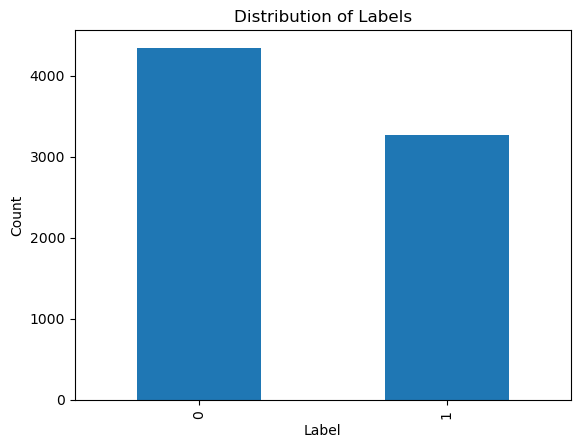

In [15]:
df['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The distribution is slightly imbalanced. I will need to take that into account when training a model.

Next, I will check the distribution of tweet length (by word count):

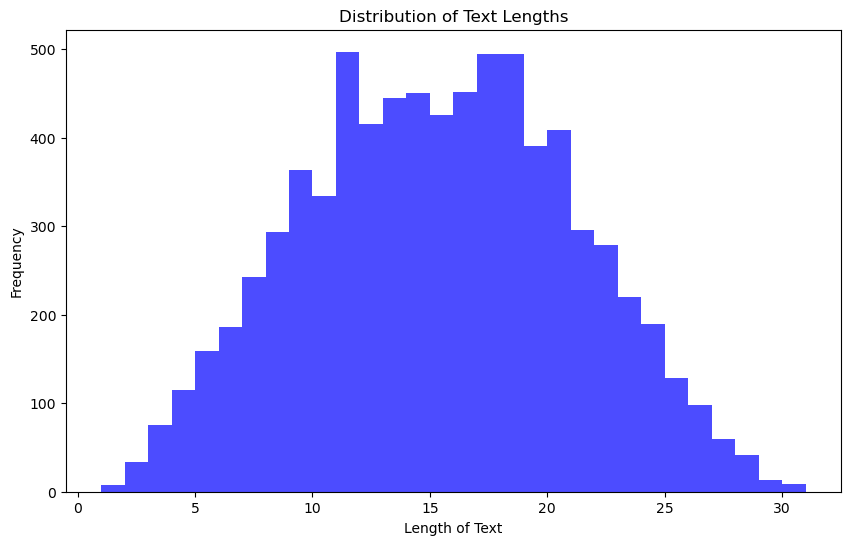

Mean length of text: 14.903585971364771
Min length of text: 1
Max length of text: 31


In [16]:
df['length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

# mean length of text
mean_length = df['length'].mean()
print(f'Mean length of text: {mean_length}')
# min length of text
min_length = df['length'].min()
print(f'Min length of text: {min_length}')
# max length of text
max_length = df['length'].max()
print(f'Max length of text: {max_length}')

The word count distribution of tweets is more or less symetric around 15, with lowest count being 1 and highest count being 31.

Here are a few more stats of the dataset:

In [17]:
# number of unique words
unique_words = df['text'].nunique()
print(f'Number of unique words: {unique_words}')
# nuber of unique keywords
unique_keywords = df['keyword'].nunique()
print(f'Number of unique keywords: {unique_keywords}')
# number of unique locations
unique_locations = df['location'].nunique()
print(f'Number of unique locations: {unique_locations}')

Number of unique words: 7503
Number of unique keywords: 221
Number of unique locations: 3341


I will also use a word cloud diagrams, to see if popular words are different per labels:

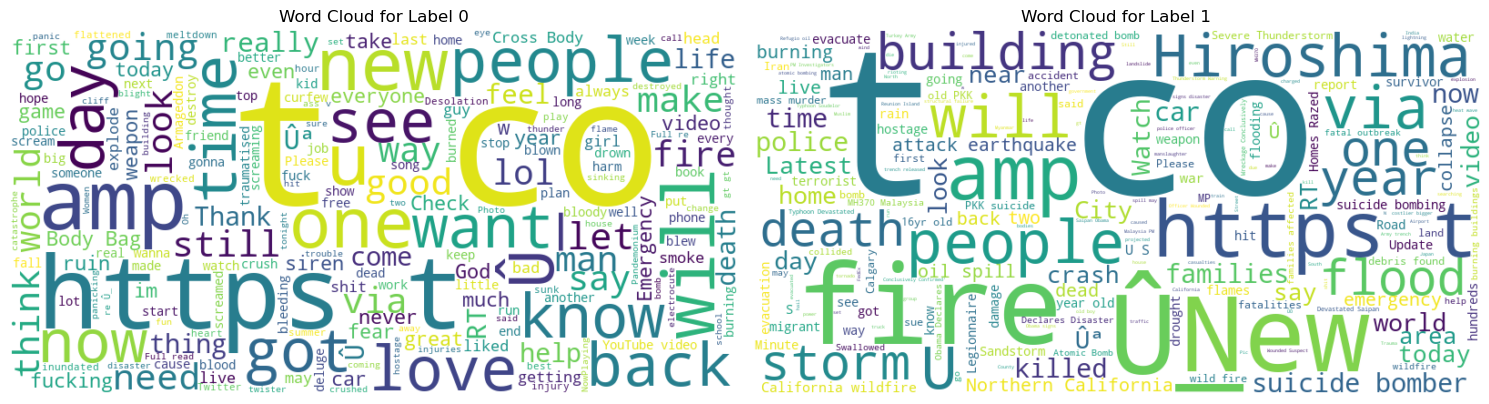

In [18]:
from wordcloud import WordCloud

plt.figure(figsize=(15, 10))
for label in df['target'].unique():
    text = ' '.join(df[df['target'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(2, 2, label + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label {label}')
plt.tight_layout()
plt.show()

Indeed, it looks like common words per label are mostly different, which can hint that simple logistic regression model can probably work for this problem as well.

After considering all the findings in this section, and running a few initial models, I decided that data cleaning is not necessary, since it is important to preserve the orignal texts. It turned out that removal of specific words (like retweet links, or mentions, or hash tags), or replacing them with tokens, degraded the performance of all models. The stop words are important to stay as well, as they can change the meaning of the sentence. However, I decided to exclude the keyword and location columns from my models, as they cannot be part of sequential data. This project focuses on RNN, so I will only use sequential data - the tweets.

One of the problem I foresee, is that the small size and noisy nature of the data will have a big effect on performance. Also, from my observation the labels of the train data are not 100% accurate. It would be very time consuming to read through all the tweets and remove inaccuracies, so I hope most of the tweets are labelled correctly.

## 3. Model Architecture
Before moving to RNN models, I would like to build a simple baseline model, based on tf-idf measure and Logistic Regression classifier. This will only serve as a comparison later.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])
y = df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       898
           1       0.81      0.67      0.73       625

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Baseline model gives an accuracy of 80% on validation set.
Now, I can work on RNN model. First, I need to tokenize the words and transform the text into sequences. This will be an input to the RNN.

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 7503 # Number of unique words
maxlen = 31 # Maximum length of sequences (number of words in each text)

# Tokenizer. This will convert the text to sequences of integers
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

print(padded_sequences.shape)  # (number of samples, maxlen)
print(padded_sequences[0]) # First sample

(7613, 31)
[ 120 4634   25    5  869    9   22  264  139 1620 4635   90   41    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


Next I will create the model itself. It will consist of 3 layers:
* Embedding - this layer will learn the text embedding. I chose the output dimension to be 128, which means each word will be embedded as a 128 length vector. Surprizingly, the embedding dimension can be as low as 10, and still result in similar accuracy. So the range of possible values here is quite big.
* SimpleRNN - the RNN layer. The dimensionality of the output is 32. I tried several values, and it seems the dimensionality values between 30 and 100 give the best results.
* Dense - the output layer. It will use the sigmoid activation function, which is a good option for binary classification.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6667 - loss: 0.6129 - val_accuracy: 0.7551 - val_loss: 0.5693
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8468 - loss: 0.4036 - val_accuracy: 0.7781 - val_loss: 0.5035
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9155 - loss: 0.2454 - val_accuracy: 0.7479 - val_loss: 0.5559
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9581 - loss: 0.1335 - val_accuracy: 0.7485 - val_loss: 0.7088
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9619 - loss: 0.1036 - val_accuracy: 0.6927 - val_loss: 0.7962
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9707 - loss: 0.0809 - val_accuracy: 0.7354 - val_loss: 0.8232
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9777 - loss: 0.0565 - val_accuracy: 0.7328 - val_loss: 0.9018
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9840 - loss: 0.0426 - val_accuracy: 0.

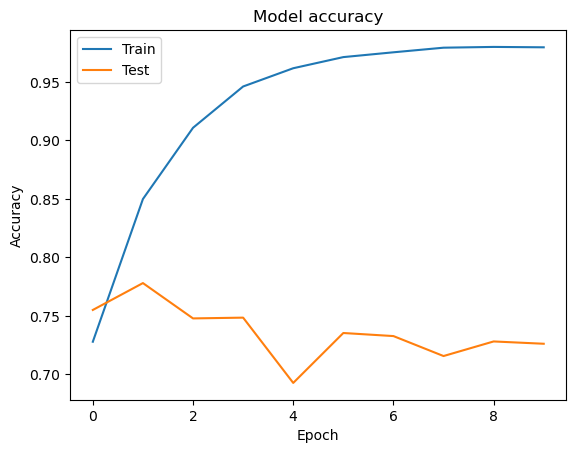

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=14)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Plot training & validation accuracy values
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

It looks like the validation accuracy peaked at the second epoch, reaching 77% and then declined. This is a sign of overfitting, since the training accuracy continued to raise and reached 97% at the last epoch. To fix this I will add a regularization in a form of Dropout layer:

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5738 - loss: 0.6693 - val_accuracy: 0.7669 - val_loss: 0.5143
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8461 - loss: 0.3949 - val_accuracy: 0.7538 - val_loss: 0.5265
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9372 - loss: 0.1970 - val_accuracy: 0.7531 - val_loss: 0.5772
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9652 - loss: 0.1167 - val_accuracy: 0.7406 - val_loss: 0.6725
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9735 - loss: 0.0796 - val_accuracy: 0.7498 - val_loss: 0.7208
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9792 - loss: 0.0623 - val_accuracy: 0.7551 - val_loss: 0.7549
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9797 - loss: 0.0558 - val_accuracy: 0.7400 - val_loss: 0.8046
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9780 - loss: 0.0555 - val_accuracy: 0.

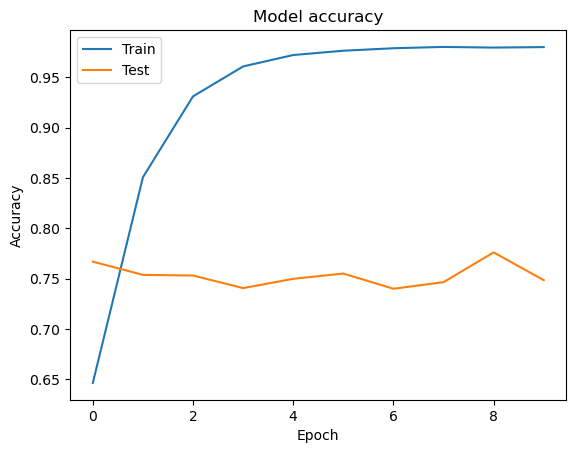

In [23]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    SimpleRNN(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

As it seems, the dropout didn't help in this case. I will discuss it in more details in the Results section.
My next model will use LSTM layer instead of vanilla RNN. LSTM can perform better on longer sequences. My sequences are 31 tokens in length, so vanilla RNN struggles with that.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6281 - loss: 0.6332 - val_accuracy: 0.7840 - val_loss: 0.4691
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8621 - loss: 0.3482 - val_accuracy: 0.7879 - val_loss: 0.4496
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9076 - loss: 0.2587 - val_accuracy: 0.7853 - val_loss: 0.5583
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9314 - loss: 0.1919 - val_accuracy: 0.7800 - val_loss: 0.6443
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9508 - loss: 0.1460 - val_accuracy: 0.7794 - val_loss: 0.6581
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9577 - loss: 0.1142 - val_accuracy: 0.7754 - val_loss: 0.7296
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9568 - loss: 0.1075 - val_accuracy: 0.7617 - val_loss: 0.8549
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9573 - loss: 0.1051 - val_accuracy: 0.

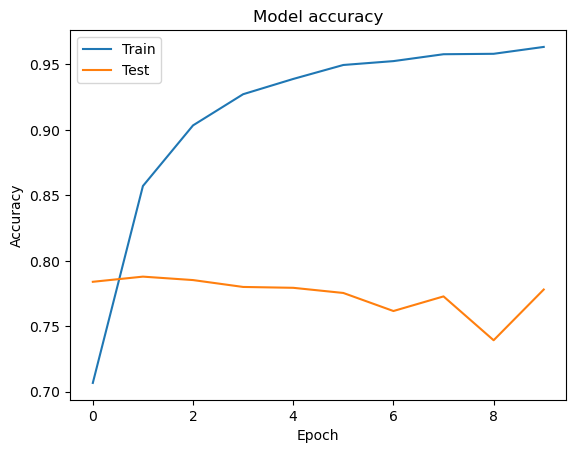

In [85]:
from tensorflow.keras.layers import LSTM

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

It looks better, but there is still overfitting. I will decrease the learning rate:

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5268 - loss: 0.6905 - val_accuracy: 0.5896 - val_loss: 0.6724
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5848 - loss: 0.6653 - val_accuracy: 0.7262 - val_loss: 0.5618
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7822 - loss: 0.4991 - val_accuracy: 0.7997 - val_loss: 0.4682
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8608 - loss: 0.3673 - val_accuracy: 0.7971 - val_loss: 0.4679
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8839 - loss: 0.3213 - val_accuracy: 0.8043 - val_loss: 0.4844
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9118 - loss: 0.2654 - val_accuracy: 0.7787 - val_loss: 0.5313
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9285 - loss: 0.2354 - val_accuracy: 0.7702 - val_loss: 0.5649
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9363 - loss: 0.2112 - val_accuracy: 0.

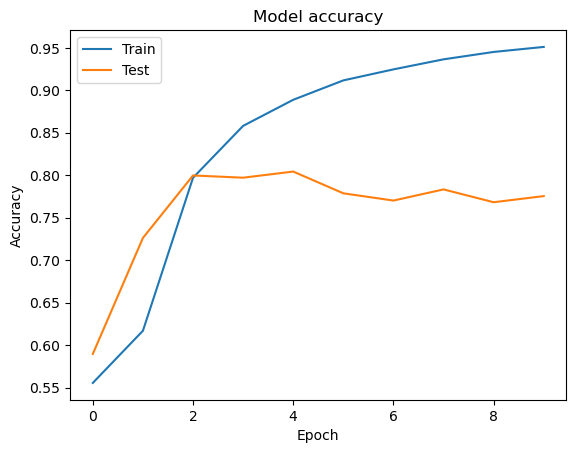

In [88]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

My next improvement will be using GRU layer instead of LSTM. It should learn faster, so I will adjust the learning rate as well:

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5530 - loss: 0.6868 - val_accuracy: 0.5896 - val_loss: 0.6804
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5590 - loss: 0.6864 - val_accuracy: 0.5896 - val_loss: 0.6785
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5702 - loss: 0.6842 - val_accuracy: 0.5896 - val_loss: 0.6782
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5662 - loss: 0.6847 - val_accuracy: 0.5896 - val_loss: 0.6779
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5686 - loss: 0.6829 - val_accuracy: 0.5988 - val_loss: 0.6515
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7094 - loss: 0.5550 - val_accuracy: 0.8076 - val_loss: 0.4472
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8665 - loss: 0.3382 - val_accuracy: 0.8109 - val_loss: 0.4465
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8952 - loss: 0.2746 - val_accuracy: 0.

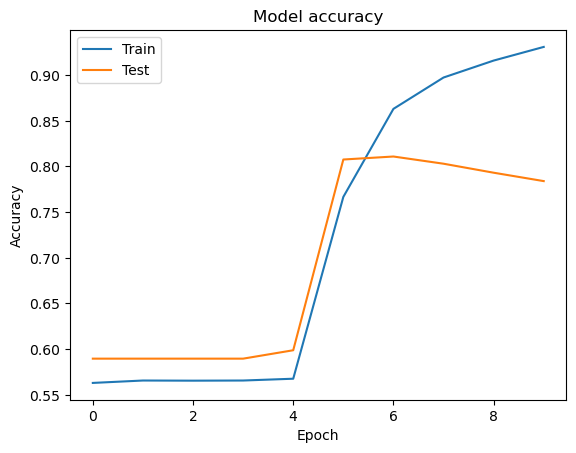

In [92]:
from tensorflow.keras.layers import GRU
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    GRU(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

The above model reached validation accuracy of 81% at 7th epoch.
Next, I will try a bi-directional layer. The rational behind it is that the meaning of the word depends not only on previous words, but also on following words. So training with both directions can be worth it:

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5714 - loss: 0.6853 - val_accuracy: 0.5896 - val_loss: 0.6715
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5777 - loss: 0.6664 - val_accuracy: 0.7072 - val_loss: 0.6281
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7299 - loss: 0.5745 - val_accuracy: 0.7695 - val_loss: 0.5078
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8290 - loss: 0.4374 - val_accuracy: 0.7925 - val_loss: 0.4635
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8661 - loss: 0.3579 - val_accuracy: 0.7984 - val_loss: 0.4485
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8861 - loss: 0.3106 - val_accuracy: 0.8011 - val_loss: 0.4582
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9024 - loss: 0.2656 - val_accuracy: 0.7951 - val_loss: 0.4754
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9156 - loss: 0.2368 - val_accu

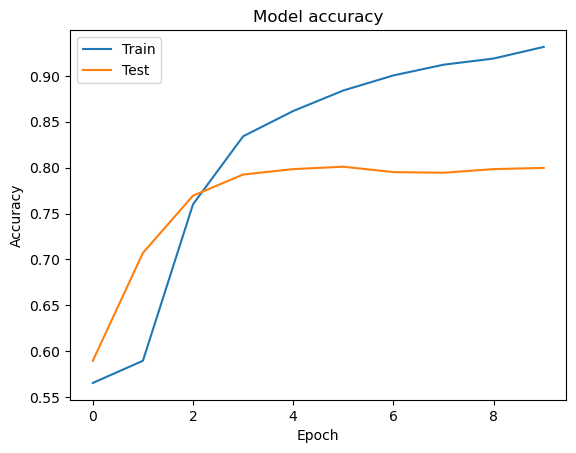

In [103]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=164),
    Bidirectional(GRU(32)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

Bidirectional layer didn't improve the accuracy.
Next I will try adding additional layer:

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5600 - loss: 0.6884 - val_accuracy: 0.5896 - val_loss: 0.6674
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6049 - loss: 0.6435 - val_accuracy: 0.7761 - val_loss: 0.5240
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8174 - loss: 0.4440 - val_accuracy: 0.8017 - val_loss: 0.4552
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8728 - loss: 0.3366 - val_accuracy: 0.8070 - val_loss: 0.4550
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8993 - loss: 0.2909 - val_accuracy: 0.7984 - val_loss: 0.4942
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9191 - loss: 0.2493 - val_accuracy: 0.7932 - val_loss: 0.5264
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9320 - loss: 0.2206 - val_accuracy: 0.7728 - val_loss: 0.5903
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9410 - loss: 0.1987 - val_accu

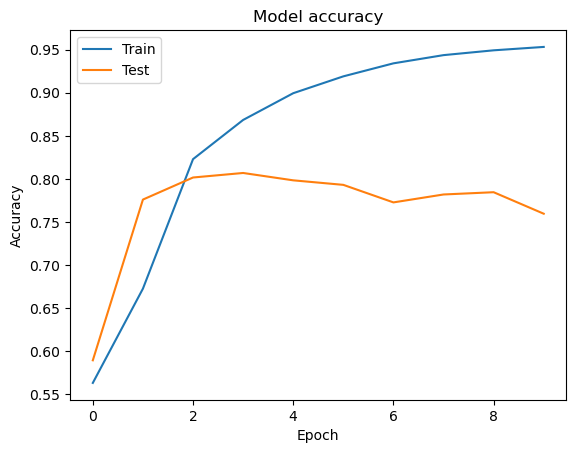

In [108]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

Again, no effect. It seems like my models are reaching a ceiling in accuracy. I will discuss it more in details in the next section, but I will note here that the dataset for this project is relatively small (10k samples) and the texts are very short (15 words on average). This probably makes it hard to train a good word embeddings from this text, with strong semantical meaning. To solve this, I will use an existing word embeddings, the GloVe. This will be my final model for this section:

In [ ]:
# creating the embedding matrix for words in the dataset

EMBEDDING_DIM = 100

embedding_index = {}

with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

word_index = tokenizer.word_index
num_words = min(vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Loaded 400000 word vectors.
Embedding matrix shape: (7503, 100)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6525 - loss: 0.6176 - val_accuracy: 0.7919 - val_loss: 0.4613
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8050 - loss: 0.4408 - val_accuracy: 0.8043 - val_loss: 0.4274
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8281 - loss: 0.3999 - val_accuracy: 0.8083 - val_loss: 0.4214
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8489 - loss: 0.3647 - val_accuracy: 0.8129 - val_loss: 0.4230
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8719 - loss: 0.3283 - val_accuracy: 0.8188 - val_loss: 0.4397


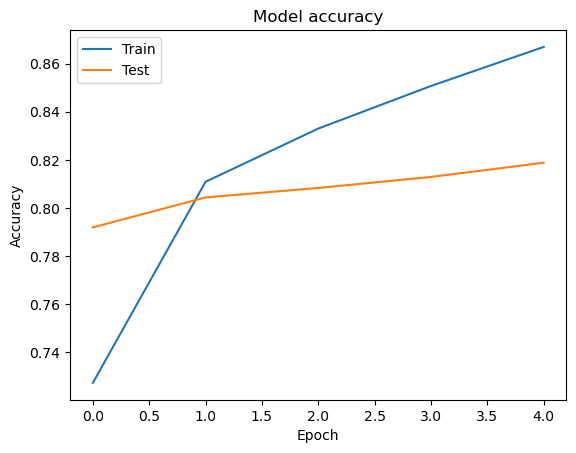

In [125]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0003)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=14)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

plot_history(history)

Ok, using GloVe embeddings slightly improved the performance. The validation accuracy reached almost 82%. I will use this model for the submission.

In [ ]:
test_df = pd.read_csv('test.csv')
test_df['text'] = test_df['text'].str.lower()
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')
predictions = model.predict(test_padded_sequences)
submission_df = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
submission_df['target'] = (submission_df['target'] > 0.5).astype(int)
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## 4. Results and Discussion
I will summarize all the results from the previous section in a table. I will only consider the accuracy as a metric. Training time is not relevant for comparison, as it was very fast for all the models.

| Model | Accuracy |
|-------|----------|
|Logistic Regression with tf-idf|80%|
|SimpleRNN with trained embeddings|78%|
|SimpleRNN + dropout|77%|
|LSTM + dropout|79%|
|GRU + dropout|81%|
|Bidirectional GRU|80%|
|2 LSTM layers|80%|
|GloVe embeddings + Bidirectional LSTM|82%|

The above results show that all the models performed very similarly, with accuracy ranging from 77% to 82%. The biggest surprize for me was that the simple Logistic Regression model with tf-idf resulted in 80% accuracy, which is only slightly worse then the best RNN model with GloVe embeddings.

I took an iterative approach for developing the architecture and tuning the hyperparameters. I wanted to explore the differences between SimpleRNN, LSTM, GRU, and bi-directional RNNs. The results do not show a clear optimal architecture, as all the models performed very similarly. Adding more layers did not have any effect on the performance. Another dificully was that parameter tuning was not the same for all the models, and each one of them required different values for dropout level and learning rate. 

#### Hyperparameter tuning - the process, what worked well and what didn't
In the previous section I performed hyperparameter tuning multiple times. The approach I took was 'trial and failure', and the goal was to see in general what helps and what not. Here is a more detailed breakdown of my findings:
* The dimensionality of the Embedding layer - this hyperparameter had a surprisingly wide range, with values between 10 and 200 giving the optimal performance. It seems that the model can learn the embeddings very quickly and don't need a high dimension vector to represent them. The reason for that might be the small size of the dataset and very short texts.
* The output dimension of the RNN layer (including LSTM, GRU, bi-directional layers) - also in this case the range could be quite big, from 16 to 128, without much effect on the performance. I think the reason is the same as in previous point. The learning is very quick and doesn't require high dimensional output.
* Dropout - This hyperparameter had very small effect on the performance. It didn't help to solve overfitting at all. The reason is that RNN layer has many weights and connections inside itself and using dropout only on the output weights doesn't solve the problem.
* Learning rate - the learning rate was very hard to tune. Different models reacted differently, but the overfitting was always present. Again, the reason for that is the small dataset and very short texts. The models peaked on 1-5 first epochs, meaning the learning was very fast. I didn't apply an early stopping mechanisms, so I could analyze the history of training epochs better.

## 5. Conclusions
I had much learnings from this project, as it was a good practical introduction for implementing RNN models, including LSTM/GRU/Bidirectional. It's a powerfull approach for cases when data can be modelled as sequence. The main takeaway, besides the practical knowledge, was that working with RNN models is different from CNN (previous project) it requires a different approach for selecting the architecture and for tuning the hyperparameters. I also saw the challenges while working with real-world data, which is noisy and doesn't follow strict rules.

#### What worked well
Given the nature of this problem, I think the RNN models performed well. The embedding layer with trained weights was very helpful. And later the GloVe embeddings helped further to reach the best accuracy with my models, which shows that semantic meaning of the words is important. Another good part was that the RNN/LSTM/GRU layers worked very fast.

#### What didn't work well
I think the main dissapointment for me was that complex RNN models didn't perform much better than a Logistic Regression with tf-idf features. It means that there wasn't much value in sequential processing of the data using RNNs, and a simple model based on word frequencies could be as efficient. As I already mentioned in the first section, the dataset for this problem is noisy and not 100% accurate. While that is a good example of a real-world problem, it didn't allow to demonstrate the power of RNNs. From what I've seen in this project's code examples on Kaggle, the best solutions were in the range of 83%-84% accuracy.

#### What improvements could I try in the future
Since the performance of my models almost reached the ceiling for this problem, I think developing a more complex architecture will not help much. Instead, if it was a real problem that I had to solve, I would implement additional functionality, beyond ML, like analysing the links, retweet rates, account credibility, and many others. If this model was used in a real emergency tracking system, I would also allow more false positives, shifting the decision value below 0, to catch boundary cases.